In [1]:
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

%matplotlib inline

# 读取样本数据
data_path = 'dataset/hour.csv'
rides = pd.read_csv(data_path)
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


# 训练数据预处理

In [2]:
# 特征变量使用 one-hot 编码
dummy_fields = ['season', 'weathersit','mnth','hr','weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each,drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,True,False,...,False,False,False,False,False,False,False,False,False,True
1,0,0,0.22,0.80,0.0,8,32,40,True,False,...,False,False,False,False,False,False,False,False,False,True
2,0,0,0.22,0.80,0.0,5,27,32,True,False,...,False,False,False,False,False,False,False,False,False,True
3,0,0,0.24,0.75,0.0,3,10,13,True,False,...,False,False,False,False,False,False,False,False,False,True
4,0,0,0.24,0.75,0.0,0,1,1,True,False,...,False,False,False,False,False,False,False,False,False,True


In [4]:
# 使用 Z-score normalization 处理数据
quant_features = ['cnt', 'temp', 'hum', 'windspeed']
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean) / std

# 将数据集分割，拆分为：测试集和训练集

In [5]:
test_data = data[-21*24:]
train_data = data[:-21*24]
print('训练数据：',len(train_data),'测试数据：',len(test_data))

训练数据： 16875 测试数据： 504


In [8]:
# 分为特征列与目标列
# 目标列
target_fields = ['cnt', 'casual', 'registered']
features, targets = train_data.drop(target_fields, axis=1), train_data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

# 将数据转换为 numpy 数组
X = features.values
Y = targets['cnt'].values
Y = Y.astype(float)
Y = np.reshape(Y, [len(Y),1])
losses = []
features.head()

,yr,holiday,temp,hum,windspeed,season_1,season_2,season_3,season_4,weathersit_1,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,-1.334609,0.947345,-1.553844,True,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True
1,0,0,-1.438475,0.895513,-1.553844,True,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True
2,0,0,-1.438475,0.895513,-1.553844,True,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True
3,0,0,-1.334609,0.636351,-1.553844,True,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True
4,0,0,-1.334609,0.636351,-1.553844,True,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True


# 构建神经网络
## 手动构建神经网络

In [ ]:
# 定义神经网络的结构
# 输入层：56 （feature.shape[1]）
# 隐含层：10
# 输出层：1

# 定义输入层单元个数
input_size = features.shape[1]
# 定义隐藏层单元个数
hidden_size = 10
# 定义输出层单元个数
output_size = 1
batch_size = 128

# input -> hidden 权重
weights_input_hidden = torch.randn([input_size, hidden_size], dtype=torch.double, requires_grad=True)
# hidden -> output 权重
weights_hidden_output = torch.randn([hidden_size, output_size], dtype=torch.double, requires_grad=True)
# hidden 偏置
bias_hidden = torch.randn([hidden_size], dtype=torch.double, requires_grad=True)

In [8]:
# 定义神经网络
input_size = features.shape[1]
hidden_size = 10
output_size = 1
batch_size = 128
neu = torch.nn.Sequential(
    torch.nn.Linear(input_size, hidden_size),
    torch.nn.Sigmoid(),
    torch.nn.Linear(hidden_size, output_size)
)
cost = torch.nn.MSELoss()
optimizer = torch.optim.SGD(neu.parameters(), lr=0.01)

for i in range(1000):
    batch_loss=[]
    for start in range(0,len(X),batch_size):
        end = start + batch_size if start + batch_size < len(X) else len(X)
        xx = torch.tensor(X[start:end], dtype=torch.float, requires_grad=True)
        yy = torch.tensor(Y[start:end], dtype=torch.float, requires_grad=True)
        predict = neu(xx)
        loss = cost(predict, yy)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.data.numpy())
    
    if i % 100 ==0:
        losses.append(np.mean(batch_loss))
        print(i, np.mean(batch_loss))

0 0.90556806
100 0.27540717
200 0.23304269
300 0.1598092
400 0.10388965
500 0.082079194
600 0.07411563
700 0.06969941
800 0.066624254
900 0.064337485


Text(0, 0.5, 'MSE')

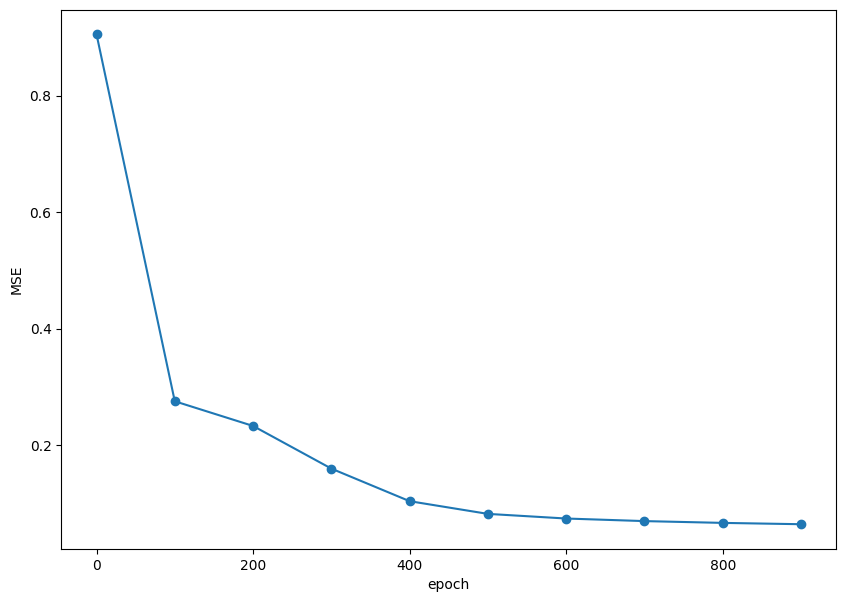

In [9]:
# 打印输出损失值
fig = plt.figure(figsize=(10, 7))
plt.plot(np.arange(len(losses))*100,losses, 'o-')
plt.xlabel('epoch')
plt.ylabel('MSE')

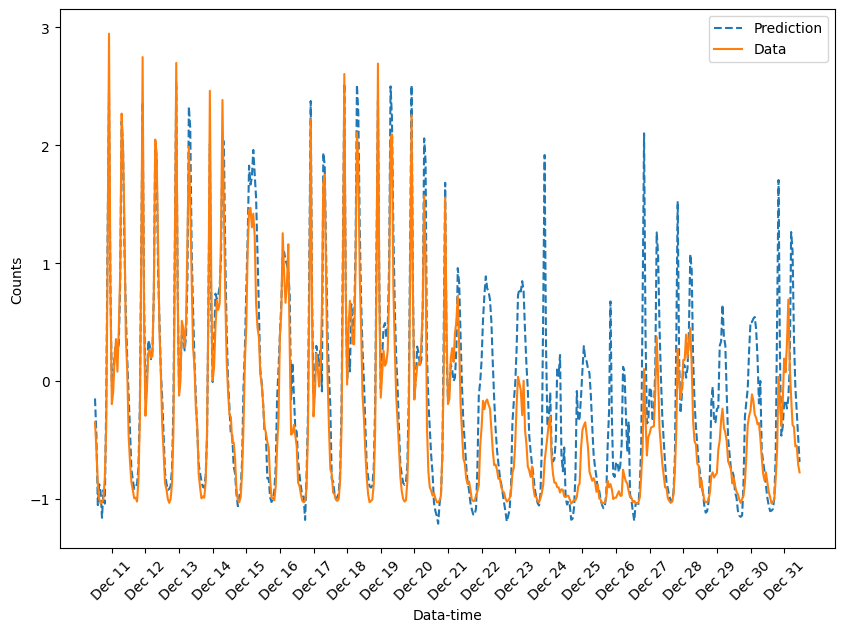

In [10]:
# 测试神经网络
targets = test_targets['cnt']
targets = targets.values.reshape([len(targets),1])
targets = targets.astype(float)

x = torch.tensor(test_features.values, dtype=torch.float)
y = torch.tensor(targets, dtype=torch.float)

predict = neu(x)
predict = predict.data.numpy()

fig,ax = plt.subplots(figsize=(10,7))

mean,std = scaled_features['cnt']
ax.plot(predict * std + mean, label='Prediction', linestyle='--')
ax.plot(targets * std + mean, label='Data', linestyle='-')

ax.legend()
ax.set_xlabel('Data-time')
ax.set_ylabel('Counts')

dates = pd.to_datetime(rides.loc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

In [11]:
# 刨析神经网络neu
def feature(X, net):
    X = torch.from_numpy(X).type(torch.FloatTensor)
    dic = dict(net.named_parameters())
    weights = dic['0.weight']
    biases = dic['0.bias']
    h = torch.sigmoid(X.mm(weights.t()) + biases.expand([len(X), len(biases)]))
    return h

In [14]:
bool1 =  rides['dteday'] == '2012-12-22'
bool2 =  rides['dteday'] == '2012-12-23'
bool3 =  rides['dteday'] == '2012-12-24'

# 将3个布尔型数组求与
bools = [any(tup) for tup in zip(bool1, bool2, bool3)]

subset = test_features.loc[rides[bools].index]
subtargets = test_targets.loc[rides[bools].index]
subtargets = subtargets['cnt']
subtargets = subtargets.values.reshape([len(subtargets),1])

result = feature(subset.values, neu).data.numpy()
predict = neu(torch.tensor(subset.values, dtype=torch.float)).data.numpy()
mean,std = scaled_features['cnt']
predict = predict * std + mean
subtargets = subtargets * std + mean

fig,ax = plt.subplots(figsize=(8,6))
ax.plot(result[:,:],'.:',alpha = 0.1)
ax.plot()